# Over expression and down regulation targets for lycopene production

We want to know which reactions, if over expressed or down regulated, affect lycopene production. This will require going through all the reactions to see whether they affect lycopene production or are affected by it. Using flux scanning based enforced objective flux (FSEOF) it is possible to see which fluxes increase or decrease as the product flux increases. This method has been validated for lycopene production in $\textit{E. coli}$ as FSEOF accuretly predicted increased lycopene production when certain genes were over expressed  (Choi et al.). We start with importing a FSEOF algorithm from the cameo package and importing our yeast model with the heterologous pathway.

In [1]:
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from cobra.io import read_sbml_model

model = read_sbml_model('models/yeast_lyco.xml')
medium=model.medium

In [2]:
fseof = FSEOF(model)

Here we use the FSEOF algorithm to identify the reactions affected by varied lycopene flux 

In [3]:
sol=fseof.run(target=model.reactions.get_by_id("CrtI"))
df=sol.data_frame;

In [4]:
df

,1,2,3,4,5,6,7,8,9,10
r_0024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003360
r_0091,0.144106,0.227637,0.311168,0.394700,0.478231,0.561762,0.408665,0.222283,0.035901,0.000000
r_0103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020691
r_0104,0.079718,0.140907,0.202095,0.263283,0.324471,0.385659,0.446658,0.507637,0.568617,0.608757
r_0215,0.021356,0.019423,0.017490,0.015556,0.013623,0.011689,0.017094,0.013151,0.009209,0.083657
...,...,...,...,...,...,...,...,...,...,...
r_4216,-0.000001,-0.000001,-0.000001,-0.000001,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
r_4262,0.106875,0.097199,0.087524,0.077848,0.068173,0.058497,0.040055,0.030816,0.021578,0.011548
r_4460,-0.262000,-0.272483,-0.282967,-0.293450,-0.303933,-0.314416,-0.322329,-0.329985,-0.337641,-0.343268
CrtB,0.007841,0.015682,0.023522,0.031363,0.039204,0.047045,0.054886,0.062726,0.070567,0.078408


There are 110 reaction fluxes affected as visualized below. Many of these are not valuable targets for gene manipulation and in the following sections we will try to extract the most obvious candidates.

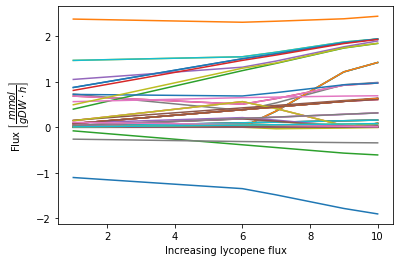

In [5]:
from matplotlib import pyplot as plt
plt.plot(df.T);
plt.xlabel("Increasing lycopene flux");
plt.ylabel(r"Flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");

# Down regulation targets

To find downregulation targets we want to look at reactions that decrease in flux as lycopene flux increases. So we weed out those values. We also want a significant change in flux, a significant flux overall and ignore values that have no flux to start with. Since there are many reactions it is prudent for this analysis to exclude a lot of the less significant ones. This is done to find the most impactful reactions because when designing a cell factory it is not easy to make a lot of changes.

In [6]:
Keys = []
for row in range(len(df[1])):
        if df[1][row]==0.0:
            continue
        elif df[1][row]>df[10][row] and abs(df[1][row]-df[10][row])/abs(df[1][row])>0.5 and df[1][row]-df[10][row]>0.1:
            Keys.append(df.index[row])
Reactions=df.T[Keys].T.sort_values(by=[10])
Reactions

,1,2,3,4,5,6,7,8,9,10
r_1696,-1.104889,-1.153733,-1.202576,-1.251419,-1.300263,-1.349106,-1.486267,-1.635465,-1.784662,-1.904454
r_1840,-0.079718,-0.140907,-0.202095,-0.263283,-0.324471,-0.385659,-0.446658,-0.507637,-0.568617,-0.608757
r_0091,0.144106,0.227637,0.311168,0.394700,0.478231,0.561762,0.408665,0.222283,0.035901,0.000000
r_0466,0.144106,0.227637,0.311168,0.394700,0.478231,0.561762,0.408665,0.222283,0.035901,-0.000000
r_0889,0.144106,0.227637,0.311168,0.394700,0.478231,0.561762,0.408665,0.222283,0.035901,-0.000000


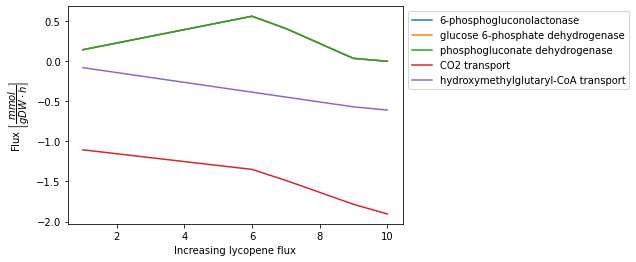

In [7]:
for k in Keys:
    plt.plot(Reactions.T[k],label=model.reactions.get_by_id(k).name)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Increasing lycopene flux");
plt.ylabel(r"Flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");

This analysis yields three down regulation targets, they direct carbon to the pentose-phosphate pathway. This might explain why intially they increase in flux and eventually fall to no flux since at optimal lycopene production there is no biomass production. So in reality they arent down regulation targets since then there would be no biomass production. Meanwhile the transport reactions are usually defined as negative fluxes, so even though they decrease in flux it is increased negative flux, so in reality we need to increase these fluxes. Below the reactions are listed in more detail.

In [8]:
for id in Reactions.index:
    r=model.reactions.get_by_id(id)
    print(r.name, id+",","final flux:", Reactions.T[id][10])
    s=""
    for rea in range(len(r.reactants)):
        if rea==len(r.reactants)-1:
            s+=r.reactants[rea].name+" ==> "
        else:
            s+=r.reactants[rea].name+" + "
    for p in range(len(r.products)):
        if p==len(r.products)-1:
            s+=r.products[p].name
        else:
            s+=r.products[p].name+" + "
    print(s)
    print()

CO2 transport r_1696, final flux: -1.904454
carbon dioxide [cytoplasm] ==> carbon dioxide [mitochondrion]

hydroxymethylglutaryl-CoA transport r_1840, final flux: -0.608757
3-hydroxy-3-methylglutaryl-CoA [cytoplasm] ==> 3-hydroxy-3-methylglutaryl-CoA [mitochondrion]

6-phosphogluconolactonase r_0091, final flux: 0.0
6-O-phosphono-D-glucono-1,5-lactone [cytoplasm] + H2O [cytoplasm] ==> 6-phospho-D-gluconate [cytoplasm] + H+ [cytoplasm]

glucose 6-phosphate dehydrogenase r_0466, final flux: -0.0
D-glucose 6-phosphate [cytoplasm] + NADP(+) [cytoplasm] ==> 6-O-phosphono-D-glucono-1,5-lactone [cytoplasm] + H+ [cytoplasm] + NADPH [cytoplasm]

phosphogluconate dehydrogenase r_0889, final flux: -0.0
6-phospho-D-gluconate [cytoplasm] + NADP(+) [cytoplasm] ==> carbon dioxide [cytoplasm] + D-ribulose 5-phosphate [cytoplasm] + NADPH [cytoplasm]



# General targets

Now we want to see which fluxes change signifigantly along with being signifigant in value. These fluxes could be good candidates for gene manipulation. We choose an increase of over 80% and a final flux above 0.3 mmol/gDW h

In [9]:
Keys = []
for row in range(len(df[1])):
    if df[1][row]!=0:
        if abs(df[1][row]-df[10][row])/abs(df[1][row])>0.8 and abs(df[10][row])>0.3:
            Keys.append(df.index[row])

In [10]:
Reactions=df.T[Keys].T.sort_values(by=[10])

In [11]:
Keys=Reactions.index
Reactions

,1,2,3,4,5,6,7,8,9,10
r_1840,-0.079718,-0.140907,-0.202095,-0.263283,-0.324471,-0.385659,-0.446658,-0.507637,-0.568617,-0.608757
r_0455,0.031363,0.062726,0.094090,0.125453,0.156816,0.188179,0.219542,0.250906,0.282269,0.313632
r_1265,0.039601,0.070218,0.100836,0.131453,0.162071,0.192688,0.223214,0.253730,0.284247,0.314690
r_1021,0.039601,0.070218,0.100836,0.131453,0.162071,0.192688,0.223214,0.253730,0.284247,0.314690
r_1129,0.079718,0.140907,0.202095,0.263283,0.324471,0.385659,0.446658,0.507637,0.568617,0.608757
r_0104,0.079718,0.140907,0.202095,0.263283,0.324471,0.385659,0.446658,0.507637,0.568617,0.608757
r_0560,0.079718,0.140907,0.202095,0.263283,0.324471,0.385659,0.446658,0.507637,0.568617,0.608757
r_0737,0.079718,0.140907,0.202095,0.263283,0.324471,0.385659,0.446658,0.507637,0.568617,0.629447
r_0739,0.079718,0.140907,0.202095,0.263283,0.324471,0.385659,0.446658,0.507637,0.568617,0.629447
r_0904,0.079718,0.140907,0.202095,0.263283,0.324471,0.385659,0.446658,0.507637,0.568617,0.629447


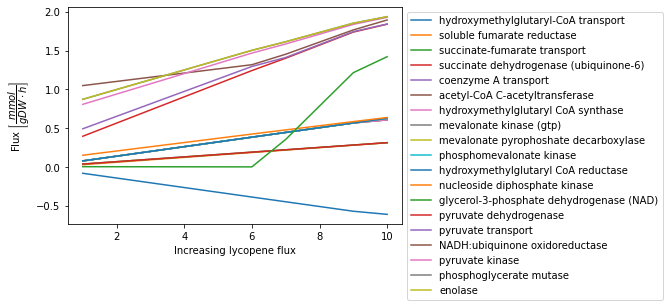

In [12]:
for k in Keys:
    plt.plot(Reactions.T[k],label=model.reactions.get_by_id(k).name)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Increasing lycopene flux");
plt.ylabel(r"Flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");

These criteria yield a more workable list of reactions.

In [13]:
for id in Reactions.index:
    r=model.reactions.get_by_id(id)
    print(r.name, id+",","final flux:", Reactions.T[id][10])
    s=""
    for rea in range(len(r.reactants)):
        if rea==len(r.reactants)-1:
            s+=r.reactants[rea].name+" ==> "
        else:
            s+=r.reactants[rea].name+" + "
    for p in range(len(r.products)):
        if p==len(r.products)-1:
            s+=r.products[p].name
        else:
            s+=r.products[p].name+" + "
    print(s)
    print()

hydroxymethylglutaryl-CoA transport r_1840, final flux: -0.608757
3-hydroxy-3-methylglutaryl-CoA [cytoplasm] ==> 3-hydroxy-3-methylglutaryl-CoA [mitochondrion]

soluble fumarate reductase r_0455, final flux: 0.313632
FADH2 [cytoplasm] + fumarate [cytoplasm] ==> FAD [cytoplasm] + H+ [cytoplasm] + succinate [cytoplasm]

succinate-fumarate transport r_1265, final flux: 0.31469
fumarate [mitochondrion] + succinate [cytoplasm] ==> fumarate [cytoplasm] + succinate [mitochondrion]

succinate dehydrogenase (ubiquinone-6) r_1021, final flux: 0.31469
succinate [mitochondrion] + ubiquinone-6 [mitochondrion] ==> fumarate [mitochondrion] + ubiquinol-6 [mitochondrion]

coenzyme A transport r_1129, final flux: 0.608757
coenzyme A [cytoplasm] ==> coenzyme A [mitochondrion]

acetyl-CoA C-acetyltransferase r_0104, final flux: 0.608757
acetyl-CoA [mitochondrion] ==> acetoacetyl-CoA [mitochondrion] + coenzyme A [mitochondrion]

hydroxymethylglutaryl CoA synthase r_0560, final flux: 0.608757
acetoacetyl-Co

A lot of the reactions above are related to the central metabolism, this is because the essential precursor for lycopene is acetyl-CoA, so a good strategy would be to direct carbon flux to the production of acetyl-CoA and decrease the flux to the citric acid cycle. This is however not optimal since the citric acid cycle is important for biomass production. Three reactions are related to fumarate, which can be reduced to succinate in FAD regenration. This is likely because FAD is necessary to oxidize phytoene to lycopene so more FAD leads to more product.

In conclusion it is hard to find obvious targets for down regulation and over expression since lycopene production competes with the central carbon metabolism for precursors. Increasing flux through our heterologous pathway and decreasing flux to the citric acid cycle seems to be the optimal solution but this will require significant fine tuning since biomass production must also be adequite.

# References 

1 H. S. Choi, S. Y. Lee, T. Y. Kim, and H. M. Woo, ‘In silico identification of gene amplification targets'